# Netflix dataset without user data
During a previous hackathon, we were given a csv containing netflix data. I only had an hour and a half to produce some code. I decided to see what I could do given more time

# Imports

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR') #prevents unnecessary mpl warnings about sns color palette

# Data Exploration

### Renaming columns & organising dtypes:

In [122]:
df = pd.read_csv("data/netflix_titles_nov_2019.csv")
df.head(3)

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"November 30, 2019",2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie


In [123]:
df.dtypes

show_id          int64
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
type            object
dtype: object

# Data Cleaning

In [124]:
cleaned_df = pd.read_csv(
    "data/netflix_titles_nov_2019.csv",
    engine="c",
    header=0, # Required to enforce our own column names
    names=[
        "netflix_id",                      # may map netflix id to imdb id later on so renaming to something clearer
        "title",
        "director",                        # NOTE: some movies can have more than 1 director?
        "cast",
        "countries",                       # pluralised since some contain multiple entries
        "date_added",
        "release_year",
        "maturity_rating",                 # Netflix labels this as "Maturity Rating", see website
        "duration",
        "genres",                          # Netflix labels this as "Genres", see website
        "web_synopsis",                    # Netflix labels this as "web_synopsis", see inspect element on website
        "type",
        ],
    dtype={
        "netflix_id": np.int32,            # FFFFFFFF -> up to 4,294,967,295
        "title": "string",
        "director": "category",
        "cast": "category",
        "countries": "category",
        "release_year": np.int16,          # FFFF -> up to 65,535
        "maturity_rating": "string",
        "duration": "string",              # For movies could be Int16() but seasons are in format of "X Season"
        "genres": "category",
        "web_synopsis": "string",
        "type": "category",
        },
    parse_dates=["date_added"],
    date_parser=lambda x: pd.to_datetime(x, format="%B %d, %Y"), # See https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    )

### Custom functions
No direct relevance to the data, feel free to colapse / ignore

In [125]:
# COPY PASTA MODIFICATION VARS - modify based on dataset:
DUPLICATE_COLS_TO_CHECK = ["INSERT COLS"] # Based on non-null cols gleaned from df.info()
DUPLICATE_VALUE_COL = "INSERT KEY" # Which col to return values from

# Summary, providing info on duplicates if asked
def mySummary(dataframe: pd.DataFrame, duplicateCheck: bool = False) -> str:
    if duplicateCheck:
        num_of_dupes = dataframe[dataframe[DUPLICATE_COLS_TO_CHECK].duplicated()][DUPLICATE_VALUE_COL].count()
        if num_of_dupes > 10:
            DUPLICATES = (num_of_dupes, "More than 10 duplicates, explore more")
        else:
            DUPLICATES = (num_of_dupes, dataframe[dataframe[DUPLICATE_COLS_TO_CHECK].duplicated()][DUPLICATE_VALUE_COL].values)

        info_string = """
            Rows: {} | Cols: {} | Duplicates: {}
            Duplicates from '{}' column: {}
            """.format(
                df.shape[0],          # rows
                df.shape[1],          # cols
                DUPLICATES[0],
                DUPLICATE_VALUE_COL,
                DUPLICATES[1],
                )
    else:
        info_string = """
            Rows: {} | Cols: {}
            """.format(
                df.shape[0],          # rows
                df.shape[1],          # cols
                )
    return info_string

In [126]:
def myInfo(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Custom info dataframe
    my_info_df = pd.DataFrame()
    my_info_df["columns"] = dataframe.keys()

    # Custom info columns
    my_info_df["missing_data"] = dataframe.isna().sum().values
    my_info_df["col_dtype"] = dataframe.dtypes.values

    my_info_df["bytes"] = dataframe.memory_usage(index=False, deep=True).values
    my_info_df["nunique"] = dataframe.nunique().values
    return my_info_df

### Custom info df

In [127]:
# COPY PASTA MODIFICATION VARS - modify based on dataset:
DUPLICATE_COLS_TO_CHECK = ["title", "duration", "release_year", "genres"] # Based on non-null cols gleaned from df.info()
DUPLICATE_VALUE_COL = "netflix_id" # Which col to return values from

print(mySummary(cleaned_df, duplicateCheck=True))
myInfo(cleaned_df)


            Rows: 5837 | Cols: 12 | Duplicates: 1
            Duplicates from 'netflix_id' column: [81072516]
            


,columns,missing_data,col_dtype,bytes,nunique
0,netflix_id,0,int32,23348,5837
1,title,0,string,444378,5780
2,director,1901,category,308762,3108
3,cast,556,category,1071903,5087
4,countries,427,category,72357,527
5,date_added,642,datetime64[ns],46696,1092
6,release_year,0,int16,11674,71
7,maturity_rating,10,string,358625,14
8,duration,0,string,373941,194
9,genres,0,category,72339,449


### Handling duplicates
Our custom info cell shows only 1 so...

In [128]:
if cleaned_df[cleaned_df['netflix_id'] == 81072516]["netflix_id"].count() > 1:  # Just to preserve the df from multiple cell runs
    cleaned_df.drop(                                                            # delete the first entry
        cleaned_df[cleaned_df['netflix_id'] == 81072516].index[0],
        inplace=True)
    cleaned_df.reset_index(inplace=True, drop=True)
# cleaned_df[cleaned_df['netflix_id'] == 81072516]

### Manually filling Rating
There's only 10 so...

In [129]:
# Display a dataframe of missing data from the "ratings" col
cleaned_df[cleaned_df["maturity_rating"].isna() == True]

,netflix_id,title,director,cast,countries,date_added,release_year,maturity_rating,duration,genres,web_synopsis,type
3767,80078037,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,2018-02-01,2015,<NA>,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take...",TV Show
4883,80161109,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,2017-04-04,2017,<NA>,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi...",Movie
5048,80144119,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,2017-03-01,2015,<NA>,115 min,Dramas,"Amid the chaos and horror of World War II, a c...",Movie
5154,80169801,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,2017-01-26,2017,<NA>,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...,Movie
5310,80039789,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,2016-12-01,2013,<NA>,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel...",TV Show
5339,80116008,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaT,2016,<NA>,60 min,Movies,Nursery rhymes and original music for children...,Movie
5440,70129452,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,2016-09-16,2010,<NA>,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...,Movie
5486,80114111,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,2016-08-15,2015,<NA>,66 min,Movies,The comic puts his trademark hilarious/thought...,Movie
5689,80092839,Fireplace 4K: Classic Crackling Fireplace from...,George Ford,NaN,NaN,2015-12-21,2015,<NA>,60 min,Movies,"The first of its kind in UHD 4K, with the clea...",Movie
5690,80092835,Fireplace 4K: Crackling Birchwood from Firepla...,George Ford,NaN,NaN,2015-12-21,2015,<NA>,60 min,Movies,"For the first time in 4K Ultra-HD, everyone's ...",Movie


In [130]:
# Create list of show_id's missing ratings data:
show_ids_missing_ratings = cleaned_df[cleaned_df["maturity_rating"].isna() == True].index.tolist()

# List of manually researched maturity ratings in the order of the previous cell::
missing_ratings = ['G','PG-14','PG-14','UR','PG','TV-G','UR','UR','G','G']

# Convert to dictionary:
nan_ratings = dict(zip(show_ids_missing_ratings, missing_ratings))

# Replace ratings using nan_ratings:
for i in nan_ratings:
    cleaned_df.loc[i, "maturity_rating"] = str(nan_ratings[i])

# Convert column "rating" dtype to category to reduce mem:
cleaned_df["maturity_rating"] = cleaned_df["maturity_rating"].astype("category")

# Show progress:
myInfo(cleaned_df)

,columns,missing_data,col_dtype,bytes,nunique
0,netflix_id,0,int32,23348,5837
1,title,0,string,444378,5780
2,director,1901,category,308762,3108
3,cast,556,category,1071903,5087
4,countries,427,category,72357,527
5,date_added,642,datetime64[ns],46696,1092
6,release_year,0,int16,11674,71
7,maturity_rating,0,category,7307,15
8,duration,0,string,373941,194
9,genres,0,category,72339,449


### Modifying the maturity rating
see:
- https://en.wikipedia.org/wiki/Television_content_rating_system
- https://us.amazon.com/gp/help/customer/display.html?nodeId=G2C2CPZWGZWHZ42J
- https://knowledgeburrow.com/what-does-a-ur-rating-mean/

Went with amazon breakdown since simpler

In [131]:
# Create a dictionary to use:
ratings_dct = {}
for i in cleaned_df["maturity_rating"].unique().categories:
    ratings_dct[i] = 0
ratings_dct

{'G': 0,
 'NC-17': 0,
 'NR': 0,
 'PG': 0,
 'PG-13': 0,
 'PG-14': 0,
 'R': 0,
 'TV-14': 0,
 'TV-G': 0,
 'TV-MA': 0,
 'TV-PG': 0,
 'TV-Y': 0,
 'TV-Y7': 0,
 'TV-Y7-FV': 0,
 'UR': 0}

In [132]:
# Copying above output & manually adding more readable data to translate to:
ratings_dct = {
'G': 0,
'NC-17': 18,
'NR': 18,
'PG': 7,
'PG-13': 13,
'R': 18,
'TV-14': 16,
'TV-G': 0,
'TV-MA': 18,
'TV-PG': 7,
'TV-Y': 0,              # Target Audience = 2-6
'TV-Y7': 7,
'TV-Y7-FV': 7,          # FV = "Fantasy Violence", may be slightly more intense than other ratings of 7
'UR': 18,               # Stands for Unrated so classified 18 by default
}
suitability_dct = {
    18: "Adult",
    16: "Young Adults",
    13: "Teens",
    7: "Older Kids",
    0: "Kids",
}
cleaned_df["age_rating"] = cleaned_df["maturity_rating"].replace(ratings_dct)
cleaned_df["suitability"] = cleaned_df["age_rating"].replace(suitability_dct)
cleaned_df["suitability"] = cleaned_df["suitability"].astype('category')

# Now we can see how this becomes more readable and easier to work with statistically:
cleaned_df[["maturity_rating", "age_rating", "suitability"]].head(10)

,maturity_rating,age_rating,suitability
0,TV-14,16,Young Adults
1,TV-G,0,Kids
2,TV-14,16,Young Adults
3,TV-14,16,Young Adults
4,TV-Y,0,Kids
5,TV-14,16,Young Adults
6,TV-MA,18,Adult
7,TV-MA,18,Adult
8,TV-14,16,Young Adults
9,TV-14,16,Young Adults


### Fixing nonsense genres.
For some reason, netflix has decided to 'redefine' genres as 'useful tags'. Let's fix this

In [133]:
# Get a list of unique 'tags'
unique_genres = set()
largest = 0
for i in cleaned_df["genres"].cat.categories:
    if ',' in i:
        i = i.split(", ")
        unique_genres.update(i)
        if len(i) > largest:
            largest = len(i)
    else:
        unique_genres.add(i)
print("Most amount of genres per title: {}".format(largest))
unique_genres


Most amount of genres per title: 3


{'Action & Adventure',
 'Anime Features',
 'Anime Series',
 'British TV Shows',
 'Children & Family Movies',
 'Classic & Cult TV',
 'Classic Movies',
 'Comedies',
 'Crime TV Shows',
 'Cult Movies',
 'Documentaries',
 'Docuseries',
 'Dramas',
 'Faith & Spirituality',
 'Horror Movies',
 'Independent Movies',
 'International Movies',
 'International TV Shows',
 "Kids' TV",
 'Korean TV Shows',
 'LGBTQ Movies',
 'Movies',
 'Music & Musicals',
 'Reality TV',
 'Romantic Movies',
 'Romantic TV Shows',
 'Sci-Fi & Fantasy',
 'Science & Nature TV',
 'Spanish-Language TV Shows',
 'Sports Movies',
 'Stand-Up Comedy',
 'Stand-Up Comedy & Talk Shows',
 'TV Action & Adventure',
 'TV Comedies',
 'TV Dramas',
 'TV Horror',
 'TV Mysteries',
 'TV Sci-Fi & Fantasy',
 'TV Shows',
 'TV Thrillers',
 'Teen TV Shows',
 'Thrillers'}

In [134]:
# Copying the above output we can generate a dictionary of sensible genres to map to
# I've tried to match the mapping to IMDB genres as best as possible (explanation will come a bit later)
genre_map = {
'Action & Adventure': ["Action", "Adventure"],
'Anime Features': "Animation",
'Anime Series': "Animation",
'British TV Shows': "British",
'Children & Family Movies': "Family",
'Classic & Cult TV': "Classic",
'Classic Movies': "Film-Noir",
'Comedies': "Comedy",
'Crime TV Shows': "Crime",
'Cult Movies': "Cult",
'Documentaries': "Documentary",
'Docuseries': "Docuseries",
'Dramas': "Drama",
'Faith & Spirituality': "Faith & Spirituality",
'Horror Movies': "Horror",
'Independent Movies': "Independent",
'International Movies': "International",
'International TV Shows': "International",
"Kids' TV": "Family",
'Korean TV Shows': "Korean",
'LGBTQ Movies': "LGBTQ",
'Movies': "Movies",
'Music & Musicals': ["Music", "Musicals"],
'Reality TV': "Reality-TV",
'Romantic Movies': "Romance",
'Romantic TV Shows': "Romance",
'Sci-Fi & Fantasy': ["Sci-Fi", "Fantasy"],
'Science & Nature TV': "Documentary",
'Spanish-Language TV Shows': "Spanish",
'Sports Movies': "Sport",
'Stand-Up Comedy': "Comedy",
'Stand-Up Comedy & Talk Shows': ["Comedy", "Talk-Show"],
'TV Action & Adventure': ["Action", "Adventure"],
'TV Comedies': "Comedy",
'TV Dramas': "Drama",
'TV Horror': "Horror",
'TV Mysteries': "Mystery",
'TV Sci-Fi & Fantasy': ["Sci-Fi", "Fantasy"],
'TV Shows': "TV Shows",
'TV Thrillers': "Thriller",
'Teen TV Shows': "Family",
'Thrillers': "Thriller"
}

In [135]:
for e,i in enumerate(cleaned_df["genres"].astype("string")): # Use .astype string to avoid issues later
    k = ''

    # If a comma doesn't exist in the string then there is only 1 'tag'
    if ', ' not in i:

        # convert i to a pandas series so that we can apply .map, then convert that to a list
        A = list(pd.Series(i).map(genre_map))

        # flatten nested lists - this is required because I've decided to split some tags up into more than 1 element. So A may be 'Thriller' or ["Sci-Fi, "Fantasy"]
        while any(isinstance(x, list) for x in A):
            for element in A:
                if type(element) == list:
                    A += element
                    A.remove(element)

        # Remove None entries
        # A = list(filter(None, A))

        if len(A):  # If not empty
                    # append properly matched genres to string
            for i in A:
                k += i + ','

            # delete trailing commas
            if k[-1] == ',':
                k = k[:-1]

            # Assign to the relevant entry
            cleaned_df.loc[e,"sensible_genres"] = k

    else:
        # same as above but just need to split:
        i = i.split(", ")
        A = list(pd.Series(i).map(genre_map))
        while any(isinstance(x, list) for x in A):
            for element in A:
                if type(element) == list:
                    A += element
                    A.remove(element)
        A = list(filter(None, A)) # Remove None entries
        if len(A): # If not empty
            for i in A:
                k += i + ','
            if k[-1] == ',':
                k = k[:-1]
            cleaned_df.loc[e,"sensible_genres"] = k

cleaned_df["sensible_genres"] = cleaned_df["sensible_genres"].astype("category")

In [136]:
# Previewing our function:
cleaned_df[["genres", "sensible_genres"]].head(10)
# cleaned_df["sensible_genres"].unique().tolist() # Everything looks good

,genres,sensible_genres
0,"International TV Shows, Korean TV Shows, Roman...","International,Korean,Romance"
1,"Documentaries, International Movies","Documentary,International"
2,"Comedies, Dramas, International Movies","Comedy,Drama,International"
3,"Dramas, Independent Movies, International Movies","Drama,Independent,International"
4,Kids' TV,Family
5,"Comedies, International Movies, Thrillers","Comedy,International,Thriller"
6,"Dramas, Independent Movies, International Movies","Drama,Independent,International"
7,"Dramas, International Movies","Drama,International"
8,"Crime TV Shows, International TV Shows, Spanis...","Crime,International,Spanish"
9,"Comedies, International Movies","Comedy,International"


In [137]:
# I'm tempted to use "web_synopsis" to apply sentiment analysis or perhaps NLP to make predictions on genre but for now I'm dropping the frame:
cleaned_df.drop("web_synopsis", axis=1, inplace=True)

In [138]:
# .lower() the case of columns used in brute force search matching later:
cleaned_df["title"] = cleaned_df["title"].str.lower()
cleaned_df["title"] = cleaned_df["title"].astype("category")
cleaned_df["director"] = cleaned_df["director"].str.lower()
cleaned_df["director"] = cleaned_df["director"].astype("category")
cleaned_df["cast"] = cleaned_df["cast"].str.lower()
cleaned_df["cast"] = cleaned_df["cast"].astype("category")
cleaned_df["countries"] = cleaned_df["countries"].str.lower()
cleaned_df["countries"] = cleaned_df["countries"].astype("category")

In [139]:
cleaned_df.head(3)

,netflix_id,title,director,cast,countries,date_added,release_year,maturity_rating,duration,genres,type,age_rating,suitability,sensible_genres
0,81193313,chocolate,NaN,"ha ji-won, yoon kye-sang, jang seung-jo, kang ...",south korea,2019-11-30,2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",TV Show,16,Young Adults,"International,Korean,Romance"
1,81197050,guatemala: heart of the mayan world,"luis ara, ignacio jaunsolo",christian morales,NaN,2019-11-30,2019,TV-G,67 min,"Documentaries, International Movies",Movie,0,Kids,"Documentary,International"
2,81213894,the zoya factor,abhishek sharma,"sonam kapoor, dulquer salmaan, sanjay kapoor, ...",india,2019-11-30,2019,TV-14,135 min,"Comedies, Dramas, International Movies",Movie,16,Young Adults,"Comedy,Drama,International"


In [140]:
print(mySummary(cleaned_df))
myInfo(cleaned_df)


            Rows: 5837 | Cols: 12
            


,columns,missing_data,col_dtype,bytes,nunique
0,netflix_id,0,int32,23348,5837
1,title,0,category,584264,5778
2,director,1901,category,308762,3108
3,cast,556,category,1071977,5087
4,countries,427,category,72357,527
5,date_added,642,datetime64[ns],46696,1092
6,release_year,0,int16,11674,71
7,maturity_rating,0,category,7307,15
8,duration,0,string,373941,194
9,genres,0,category,72339,449


# Filling data 2 methods:
Statistical approach
There are 2 methods that spring to mind:
- filling using statistical modelling - (generated samples so less acurate )
- scraping / merging - use another reliable dataset to compliment this one

I will do the latter first since by default one wants the most accurate data possible

## Statistical approach
**Pros**
- Fast to implement
- Simple to implement
- Easy to read
- Easy to understand
- Doesn't require external information

**Cons**
- potentially less accurate
- Constrained to the given data

In [141]:
statistical_method_df = cleaned_df.copy()

Since we're constrained to only what's presented we can't really use directors.
Cast could be use but we'd need to account for the missing data somehow
For now droping both but might come back to cast as there may be fun insights from it

In [142]:
statistical_method_df.drop("director", axis=1, inplace=True)
statistical_method_df.drop("cast", axis=1, inplace=True)

Fill 'countries' using mode:

In [143]:
statistical_method_df['countries'].fillna(statistical_method_df['countries'].mode()[0], inplace=True)

Fill 'date_added' using ffill

In [144]:
statistical_method_df['date_added'].ffill(inplace=True)

Now we have a fully cleaned dataframe ready for data visualisation...

In [145]:
print(mySummary(statistical_method_df))
myInfo(statistical_method_df)


            Rows: 5837 | Cols: 12
            


,columns,missing_data,col_dtype,bytes,nunique
0,netflix_id,0,int32,23348,5837
1,title,0,category,584264,5778
2,countries,0,category,72357,527
3,date_added,0,datetime64[ns],46696,1092
4,release_year,0,int16,11674,71
5,maturity_rating,0,category,7307,15
6,duration,0,string,373941,194
7,genres,0,category,72339,449
8,type,0,category,6071,2
9,age_rating,0,category,6247,6


## Scraping / Merging approach
**Pros**
- Potentially more accurate depending on source
- Usually tailor made to a specific problem
- 'Outside the box thinking' flex?
- Allows us to expand our dataset for more insight

**Cons**
- Potentially less accurate depending on source
- Requires more time to impliment
- Can get complex very fast
  - Requires much more coffee
  - Potential multiple hair loss moments

### Filling using IMDB dataset
see https://www.imdb.com/interfaces/

Cleaned IMDB Datasets in imdb_cleaner.ipynb

Basically downscaled 5.68Gb data to 623Mb

In [146]:
# Load Data:
actors_df = pd.read_feather("data/actors.feather")
directors_df = pd.read_feather("data/directors.feather")
imdb_df = pd.read_feather("data/imdb_final_df_v3.feather")

In [147]:
directors_df.head(3)

,tconst,category,primaryName,knownForTitles
0,tt0000001,director,William K.L. Dickson,"tt0219560,tt0308254,tt1428455,tt1496763"
1,tt0000005,director,William K.L. Dickson,"tt0219560,tt0308254,tt1428455,tt1496763"
2,tt0000006,director,William K.L. Dickson,"tt0219560,tt0308254,tt1428455,tt1496763"


In [148]:
actors_df.head(3)

,tconst,category,primaryName
0,tt0177707,actor,William K.L. Dickson
1,tt0240586,actor,William K.L. Dickson
2,tt0241373,actor,William K.L. Dickson


In [149]:
imdb_df.head(3)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,miss jerry,1894,45,Romance,5.3,204
1,tt0000147,movie,the corbett-fitzsimmons fight,1897,100,"Documentary,News,Sport",5.3,465
2,tt0000502,movie,bohemios,1905,100,NaN,4.1,15


In [150]:
# Change the names to lowercase:
directors_df["primaryName"] = directors_df["primaryName"].str.lower()
actors_df["primaryName"] = actors_df["primaryName"].str.lower()

# Matching netflix_id to imdb_id

### This is a heavy function & a first attempt
- Might need to remove all special characters from titles - possibly replace with a space?
  - How does FuzzyWuzzy perform?
  - Make search multithreaded?
    - Rebuild function as class?

In [151]:
missing = {} # Contains the title and number of entries remaining in the search dataframe - FOR HIGHLIGHTING ISSUES
missing_df = {} # Contains the title and the last search dataframe - FOR INSPECTING ISSUES
breakvar = 500 # How many entries to attempt this on - (Temporary var)

for e, i in enumerate(cleaned_df["title"]):
    if e > breakvar: # just for whilst we flesh out the code
        break

    # ========> SETTING COMMON VARS:

    current = cleaned_df[cleaned_df["title"] == i].copy()           # Create dataframe with the current iterations title (Dtype: "pd.DataFrame")

    titleType = current["type"].values[0]                           # Current iterations Title Type respecting the naming convention of imdb_df (Dtype: "string")
    if titleType == "Movie":
        titleType = "movie"
    else:
        titleType = "tvSeries"

    startYear = current["release_year"].values[0]                   # Current iterations start year (Dtype: "Int16")

                                                                    # Create a list of directors in the current iterations director column (Dtype: "category")
    if current[~current['director'].isna()].shape[0]:               # If dataframe is not empty
        str_of_directors = current["director"].values[0]            # Genres is a category dtype so need to convert to a str
        if ', ' in str(str_of_directors):                           # If ', ' is in the string then there's more than 1 entry
            list_of_directors = str_of_directors.split(", ")
        else:
            list_of_directors = [str_of_directors]                  # Otherwise there's a single entry
    else:
        list_of_directors = []                                      # Otherwise there's a nan and we need to set the variable to empty to prevent wrong values carrying over to the next iteration

                                                                    # Create a list of actors in the current iterations cast column (Dtype: "category")
    if current[~current['cast'].isna()].shape[0]:
        str_of_actors = current["cast"].values[0]
        if ', ' in str(str_of_actors):
            list_of_actors = str_of_actors.split(", ")
        else:
            list_of_actors = [str_of_actors]
    else:
        list_of_actors = []

                                                                    # Create a list of genres in the current iterations genres column (Dtype: "category")
    if current[~current['genres'].isna()].shape[0]:
        str_of_genres = current["genres"].values[0]
        if ', ' in str(str_of_genres):
            list_of_genres = str_of_genres.split(", ")
        else:
            list_of_genres = [str_of_genres]
    else:
        list_of_genres = []



    # ========> SEARCH SECTION
    # 1: Filter by title & title type
    search1 = imdb_df[imdb_df["primaryTitle"] == i.lower()]
    search2 = search1[search1["titleType"] == titleType]



    if search2.shape[0] == 1:                                                                           # if single entry is found add imdb_id to dataframe:
        cleaned_df.loc[e, "imdb_id"] = search2["tconst"].values[0]
        continue
    elif search2.shape[0] == 0:                                                                         # Check if NOTHING is found, add to missing dicts & continue to next iteration:
        missing[(current["title"].values[0])] = search2.shape[0]
        missing_df[(current["title"].values[0])] = search2
        continue


    # 2: Try to match release year
    search3 = search2[search2["startYear"] == startYear]

    if search3.shape[0] == 1:                                                                           # if single entry is found add imdb_id to dataframe:
        cleaned_df.loc[e, "imdb_id"] = search2["tconst"].values[0]
        continue

                                                                                                        # Set secondary_search to the df that contains the lowest values that isn't 0
    if (search3.shape[0] < search2.shape[0]) & (search3.shape[0] != 0):
        secondary_search = search3.copy()
    else:
        secondary_search = search2.copy()



    # 3: Try to match the director
    lst_tconst = list(secondary_search["tconst"])                                                       # list of remaining imdb_id's from the shortest list above. NOTE: May need revising to longest list, does not account for cases where release years don't match due to user input error
    tmp_directors = directors_df[directors_df["tconst"].isin(lst_tconst)] #
    lst_director = list(set(tmp_directors["primaryName"]) & set(list_of_directors))                     # Trying to avoid using .isin due to processing speed
    if len(lst_director) == 1:
        tmp_tconst = tmp_directors[tmp_directors["primaryName"]==lst_director[0]]["tconst"].values[0]
        cleaned_df.loc[e, "imdb_id"] = tmp_tconst
        continue


    # 4: Try to match actors
    lst_tconst = list(secondary_search["tconst"])                                                       # list of remaining imdb_id's
    tmp_actors = actors_df[actors_df["tconst"].isin(lst_tconst)]                                        # create a df of these id's if they're in the actors_df
    lst_actor = list(set(tmp_actors["primaryName"]) & set(list_of_actors))                              # Get a union of matching actors between cleaned_df & the above df (which is essentially a union of imdb_df & actors_df)
    dct_tconst = {}
    for i in lst_actor:                                                                                 # For each actor that matches
        try:                                                                                            # create a key:value pair that counts each occurence of tconst
            dct_tconst[tmp_actors[tmp_actors["primaryName"] == i]["tconst"].values[0]] += 1
        except KeyError:
            dct_tconst[tmp_actors[tmp_actors["primaryName"] == i]["tconst"].values[0]] = 1
    try:
        cleaned_df.loc[e, "imdb_id"] = max(dct_tconst.keys())                                           # The key with the highest matching count gets added
    except ValueError:
        missing[(current["title"].values[0])] = secondary_search.shape[0]
        missing_df[(current["title"].values[0])] = secondary_search
    continue


### NEARLY THERE!! FOR THE MOST PART IT WORKS EXCEPT FOR WHEN TITLES Aren't an exact match!!
### The last thing to do is write a function that can cover for search1 when it fails.
### Possible solution fuzzy search with confidence values?

print(missing)
cleaned_df.head(breakvar)

{'little singham: mahabali': 0, 'mike birbiglia: the new one': 0, 'super monsters save christmas': 0, 'the crime': 0, 'true: winter wishes': 0, 'what the f* is going on?': 0, 'mike birbiglia: what i should have said was nothing: tales from my secret public journal': 0, 'shelby american': 0, 'dorasaani': 0, 'holiday secrets': 0, 'lorena, light-footed woman': 0, 'who killed little gregory?': 0, 'iliza shlesinger: unveiled': 0, 'miss culinary': 0, 'jeff dunham: all over the map': 0, 'el sendero de la anaconda': 0, 'inheritors': 0, 'westside story': 0, 'fadily camara : la plus drôle de tes copines': 0, 'maradona in mexico': 0, 'harvey street kids': 0, 'jeff garlin: our man in chicago': 0, 'greatest events of wwii in colour': 0, 'hit & run': 4, 'scams': 0, 'shadow': 2, 'luccas neto in: summer camp': 0, 'seth meyers: lobby baby': 0, 'a holiday engagement': 0, 'christmas crush': 0, 'dear santa': 3, 'the devil next door': 0, '100 things to do before high school': 0, 'a fairly odd summer': 0, '

,netflix_id,title,director,cast,countries,date_added,release_year,maturity_rating,duration,genres,type,age_rating,suitability,sensible_genres,imdb_id
0,81193313,chocolate,NaN,"ha ji-won, yoon kye-sang, jang seung-jo, kang ...",south korea,2019-11-30,2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",TV Show,16,Young Adults,"International,Korean,Romance",tt11214028
1,81197050,guatemala: heart of the mayan world,"luis ara, ignacio jaunsolo",christian morales,NaN,2019-11-30,2019,TV-G,67 min,"Documentaries, International Movies",Movie,0,Kids,"Documentary,International",tt11505398
2,81213894,the zoya factor,abhishek sharma,"sonam kapoor, dulquer salmaan, sanjay kapoor, ...",india,2019-11-30,2019,TV-14,135 min,"Comedies, Dramas, International Movies",Movie,16,Young Adults,"Comedy,Drama,International",tt8304386
3,81082007,atlantics,mati diop,"mama sane, amadou mbow, ibrahima traore, nicol...","france, senegal, belgium",2019-11-29,2019,TV-14,106 min,"Dramas, Independent Movies, International Movies",Movie,16,Young Adults,"Drama,Independent,International",tt10199586
4,80213643,chip and potato,NaN,"abigail oliver, andrea libman, briana buckmast...","canada, united kingdom",NaT,2019,TV-Y,2 Seasons,Kids' TV,TV Show,0,Kids,Family,tt9897038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,70128696,the bounty hunter,andy tennant,"jennifer aniston, gerard butler, jason sudeiki...",united states,2019-10-01,2010,PG-13,111 min,"Action & Adventure, Comedies, Romantic Movies",Movie,13,Teens,"Comedy,Romance,Action,Adventure",tt1038919
496,70077542,the bucket list,rob reiner,"jack nicholson, morgan freeman, sean hayes, be...",united states,2019-10-01,2007,PG-13,97 min,"Comedies, Dramas",Movie,13,Teens,"Comedy,Drama",tt0825232
497,81168342,the cruise,marek piwowski,"jan himilsbach, stanislaw tym, jerzy dobrowols...",poland,2019-10-01,1970,TV-PG,66 min,"Comedies, Cult Movies, International Movies",Movie,7,Older Kids,"Comedy,Cult,International",tt0066289
498,81165772,the figurine (araromire),kunle afolayan,"ramsey nouah, omoni oboli, kunle afolayan, fun...",nigeria,2019-10-01,2009,TV-14,121 min,"Horror Movies, International Movies, Thrillers",Movie,16,Young Adults,"Horror,International,Thriller",NaN


So from the above output we can see that a lot of titles can't be matched at all. How many missing titles would we have if we wrote another function that handled this:

In [ ]:
def is_not_zero(dct_items):
    if dct_items[1] != 0:
        return dct_items[0]

missing_not_zero = dict(filter(is_not_zero,missing.items()))
print("""
      Current missing matches: {} of {}
      But...
      After improving initial search:   ~{} of {}
      """.format(
          len(missing),
          breakvar,
          len(missing_not_zero),
          breakvar
          )
      )


      Current missing imdb_id's: 102 of 500
      But...
      After implementing fuzzy:   ~7 of 500
      


# FuzzyWuzzy Function

In [153]:
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer

unique_titles_imdb = imdb_df["primaryTitle"].unique().tolist() # 6kk list
unique_titles_imdb

def is_zero(dct_items):
    if dct_items[1] == 0:
        return dct_items[0]

missing_zero = list(dict(filter(is_zero, missing.items())).keys())

%time process.extract(missing_zero[0], unique_titles_imdb, scorer=fuzz.token_sort_ratio)

# This isn't viable, it takes 57.4 seconds to find 1 missing entry. Which means it'd take ~ 10 hours for the whole netflix dataset.

CPU times: total: 40.7 s
Wall time: 40.7 s


[('little singham', 76),
 ('little manhattan', 67),
 ('my little song', 65),
 ('singa machan charlie', 65),
 ('little malabar', 65)]

# Tokenized Approach:

After giving this some thought I decided to consider a tokenized approach.

After watching https://www.youtube.com/watch?v=4ohTsblxOJs& and following their slides https://www.slideshare.net/godatadriven/pydata-amsterdam-name-matching-at-scale I decided to try this approach

In [154]:
# Imports
import sys
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from scipy.sparse import csr_matrix, csc_matrix

### Clean Data

First we want to clean our title names & replace all special characters with a space:

In [155]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

def tocleanstring(s):
    try:
        s = str(s)
    except:
        pass

    s = s.replace("-", " ").replace("_", " ").replace(":", " ").replace(".", " ").replace(",", " ").replace("*", " ")
    s = s.translate(tbl)
    normalized = unicodedata.normalize("NFKD", s)
    only_ascii = normalized.encode("ASCII", "ignore")
    return only_ascii

In [156]:
cleaned_df["title_cleaned"] = cleaned_df[["title"]].applymap(tocleanstring)
cleaned_df.head()

,netflix_id,title,director,cast,countries,date_added,release_year,maturity_rating,duration,genres,type,age_rating,suitability,sensible_genres,imdb_id,title_cleaned
0,81193313,chocolate,NaN,"ha ji-won, yoon kye-sang, jang seung-jo, kang ...",south korea,2019-11-30,2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",TV Show,16,Young Adults,"International,Korean,Romance",tt11214028,b'chocolate'
1,81197050,guatemala: heart of the mayan world,"luis ara, ignacio jaunsolo",christian morales,NaN,2019-11-30,2019,TV-G,67 min,"Documentaries, International Movies",Movie,0,Kids,"Documentary,International",tt11505398,b'guatemala heart of the mayan world'
2,81213894,the zoya factor,abhishek sharma,"sonam kapoor, dulquer salmaan, sanjay kapoor, ...",india,2019-11-30,2019,TV-14,135 min,"Comedies, Dramas, International Movies",Movie,16,Young Adults,"Comedy,Drama,International",tt8304386,b'the zoya factor'
3,81082007,atlantics,mati diop,"mama sane, amadou mbow, ibrahima traore, nicol...","france, senegal, belgium",2019-11-29,2019,TV-14,106 min,"Dramas, Independent Movies, International Movies",Movie,16,Young Adults,"Drama,Independent,International",tt10199586,b'atlantics'
4,80213643,chip and potato,NaN,"abigail oliver, andrea libman, briana buckmast...","canada, united kingdom",NaT,2019,TV-Y,2 Seasons,Kids' TV,TV Show,0,Kids,Family,tt9897038,b'chip and potato'


Modified TFIDFVectorizer:

In [157]:
# Modify TFIDFVectorizer so that we aren't ignoring unseen tokens:
def modified_TFIDF_matrix(inputmatrix, preprocessor, word_to_index_dict, idf_weights, max_idf_score, n_original_features):
    docs = np.array(inputmatrix)
    nrow = docs.shape[0]
    indptr = [0]
    indices = []
    data = []
    vocabulary = word_to_index_dict
    for d in docs:
        d = preprocessor(d)
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            if (index == len(vocabulary)-1):
                idf_weights.append(max_idf_score)
            indices.append(index)
            data.append(idf_weights[index])
        indptr.append(len(indices))
    result = preprocessing.normalize(csr_matrix((data, indices, indptr), shape = (nrow, len(vocabulary)), dtype=float))
    result = result.tocsc()
    return result[:,:n_original_features]

# Will revisit this once I figure out what token_pattern works best for this dataset


imports

In [158]:
from sparse_dot_topn import awesome_cossim_topn

### Build G

In [159]:
tfidf = TfidfVectorizer(decode_error='strict', token_pattern='(?u)\\b\\w+\\b')

In [160]:
tfidf.fit(cleaned_df["title_cleaned"])

TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')

In [161]:
tokenizer = tfidf.build_analyzer()

In [162]:
G = tfidf.transform(cleaned_df["title_cleaned"])

### Build S

In [163]:
tfidf2 = TfidfVectorizer(decode_error='strict', token_pattern='(?u)\\b\\w+\\b')

In [164]:
tfidf.fit(cleaned_df["title_cleaned"])

TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')

In [165]:
tokenizer = tfidf.build_analyzer()

In [166]:
S = tfidf.transform(cleaned_df["title_cleaned"]) # And this is where I realise that this isn't going to work as G.shape[0] is not going to match the length of S.transpose().shape[1]
# Ugh I thought I was being so clever too...

Okay so will have to revisit this. I think what I'm going to do instead is something similar to the 4th search method I previously wrote. 
Create new function after the first such that all missing values that returned 0 matches goes through this logic:
- Clean each string so that only alphanumeric values remain. No special chars like :,-,*,/ etc
- .split(" ") to list each string
- decide on next method
  - Ngrams? - Might be better than simply comparing the occurence of each word. How will this fare against titles like: "what the f* is going on?" where short length may cause issues?
  - Some clever way to use tokenization, but again consider titles like: "the commonality of each of these words and their" - the commonality of each of these words is likely going to be quite high, so that might throw off the confidence ratings
  - Some really bad brute force method written by me - reliable but laughably slow.
    - Consider pyxDamerauLevenshtein instead of FuzzyWuzzy - According to online performance statistics this may be sufficient for this project?
      - Requires Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
        - Need to troubleshoot install error

## Brief - tasks we want to achieve - Nathan
- Countries v Amount (TV & Movies) - DONE
- Countries v Year
- Group Type & Average the duration:
- Most active Director
- Graphs of the above

## Deeper analysis / If we had time - Ryan / Karen
- How does this data correspond to all movies not just movies on netflix?>
- How quickly do movies appear on netflix after being released?
- Top actors on netflix?
  - Top actors on netflix per country?
- Top Directors on netflix?
  - Top Directors on netflix per country?
- min vs max of duration (movies & tv show)
- We'd clean up the graph to make each country more comparible

Talk about code - Ryan

# VISUALS {WIP}
The above functions took me a day or so, will focus on visuals for now and come back to the above a bit later

- Find a better way to compare 3 countries below

Movie Dataframe

In [167]:
df_movies = df[ df["type"] == "Movie" ]

In [168]:
# Not using due to time constraints
df_tv = df[ df["type"] == "TV Show" ]

#### Dataframe of highest **movie producing country**:

In [169]:
#NOTE: WITH MORE TIME REVISIT THIS
test2 =  df_movies[ df_movies["country"].str.contains(',') == False ] # This is really bad practice but due to time constraints I'm removing all rows with multiple countries
# Need to write function that counts each country per title
df_count_of_movies_by_country = test2.groupby("country", as_index=False)["country"].agg({"movie_count":"count"}).sort_values("movie_count", ascending=False)
df_count_of_movies_by_country.head(3)

,country,movie_count
52,United States,1375
22,India,645
51,United Kingdom,162


#### The 3 highest **movie** producing countries are:

In [170]:
top_3 = df_count_of_movies_by_country.head(3)
lst_top3 = list(top_3["country"])
lst_top3

['United States', 'India', 'United Kingdom']

#### Plot of countries that have produced the most **movies**

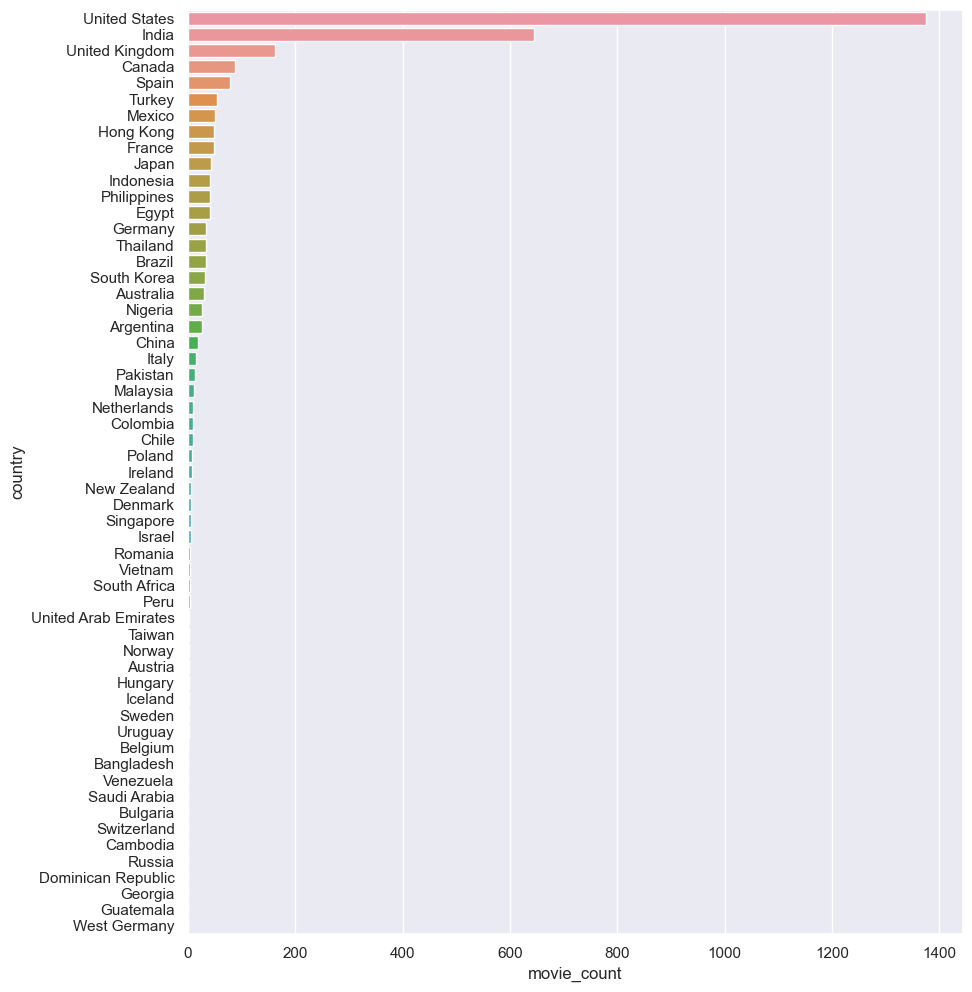

In [171]:
plt.figure(figsize=(10,12))

plt_movie = sns.barplot(
    df_count_of_movies_by_country,
    x="movie_count", y="country"
)

#### Dataframe of **years and countries**:
Can we infer growth rate of real world data?
Let's analyse the top 3 countries:

In [172]:
test5 = df_movies[ (df_movies["country"].str.contains(',') == False) & (df_movies["country"].isin(lst_top3) == True) ]
test5.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
16,81033086,Holiday Rush,Leslie Small,"Romany Malco, Sonequa Martin-Green, Darlene Lo...",United States,"November 28, 2019",2019,TV-PG,94 min,"Children & Family Movies, Dramas",A widowed radio DJ and his four spoiled kids n...,Movie
23,70101696,Defiance,Edward Zwick,"Daniel Craig, Liev Schreiber, Jamie Bell, Alex...",United States,"November 27, 2019",2008,R,137 min,"Action & Adventure, Dramas",In this action-packed drama based on an extrao...,Movie
24,81194544,Evvarikee Cheppoddu,Basava Shankar Eeday,"Rakesh Varre, Gargeyi, Vamsi raj Nekkanti, D P...",India,"November 27, 2019",2019,TV-14,134 min,"Comedies, International Movies, Romantic Movies",When caste differences throw a wrench into the...,Movie
27,80175798,The Irishman,Martin Scorsese,"Robert De Niro, Al Pacino, Joe Pesci, Harvey K...",United States,"November 27, 2019",2019,R,209 min,Dramas,Hit man Frank Sheeran looks back at the secret...,Movie


In [173]:
df_count_of_movies_by_country_by_year = test5.groupby(["country","release_year"], as_index=False)["title"].count().rename(columns={"title":"count"})
df_count_of_movies_by_country_by_year.head(3)

,country,release_year,count
0,India,1959,1
1,India,1962,1
2,India,1966,1


Function to make each df comparable:

In [204]:
df_count_of_movies_by_country_by_year.sort_values("count", inplace=True, ascending=False)

def comparable_df(country: str, year_to_start: int) -> pd.DataFrame:
    year_lst = []
    movies_df = df_count_of_movies_by_country_by_year[ df_count_of_movies_by_country_by_year["country"] == country ]
    for i in range(2023 - year_to_start):
        i += year_to_start
        year_lst.append(i)
    tmp_df = pd.DataFrame({
        "country": country,
        "release_year": year_lst,
        "count": 0
        })
    tmp_df = pd.merge(tmp_df, movies_df, right_on="release_year",left_on="release_year", how="left")
    tmp_df.drop("country_y", axis=1, inplace=True)
    tmp_df.drop("count_x", axis=1, inplace=True)
    tmp_df.rename(columns={"country_x":"country", "count_y":"count"}, inplace=True)
    tmp_df["count"].fillna(0, inplace=True)
    return tmp_df

In [205]:
year_to_start = 1942
movies_US = comparable_df(country="United States", year_to_start=year_to_start)
movies_INDIA = comparable_df(country="India", year_to_start=year_to_start)
movies_UK = comparable_df(country="United Kingdom", year_to_start=year_to_start)

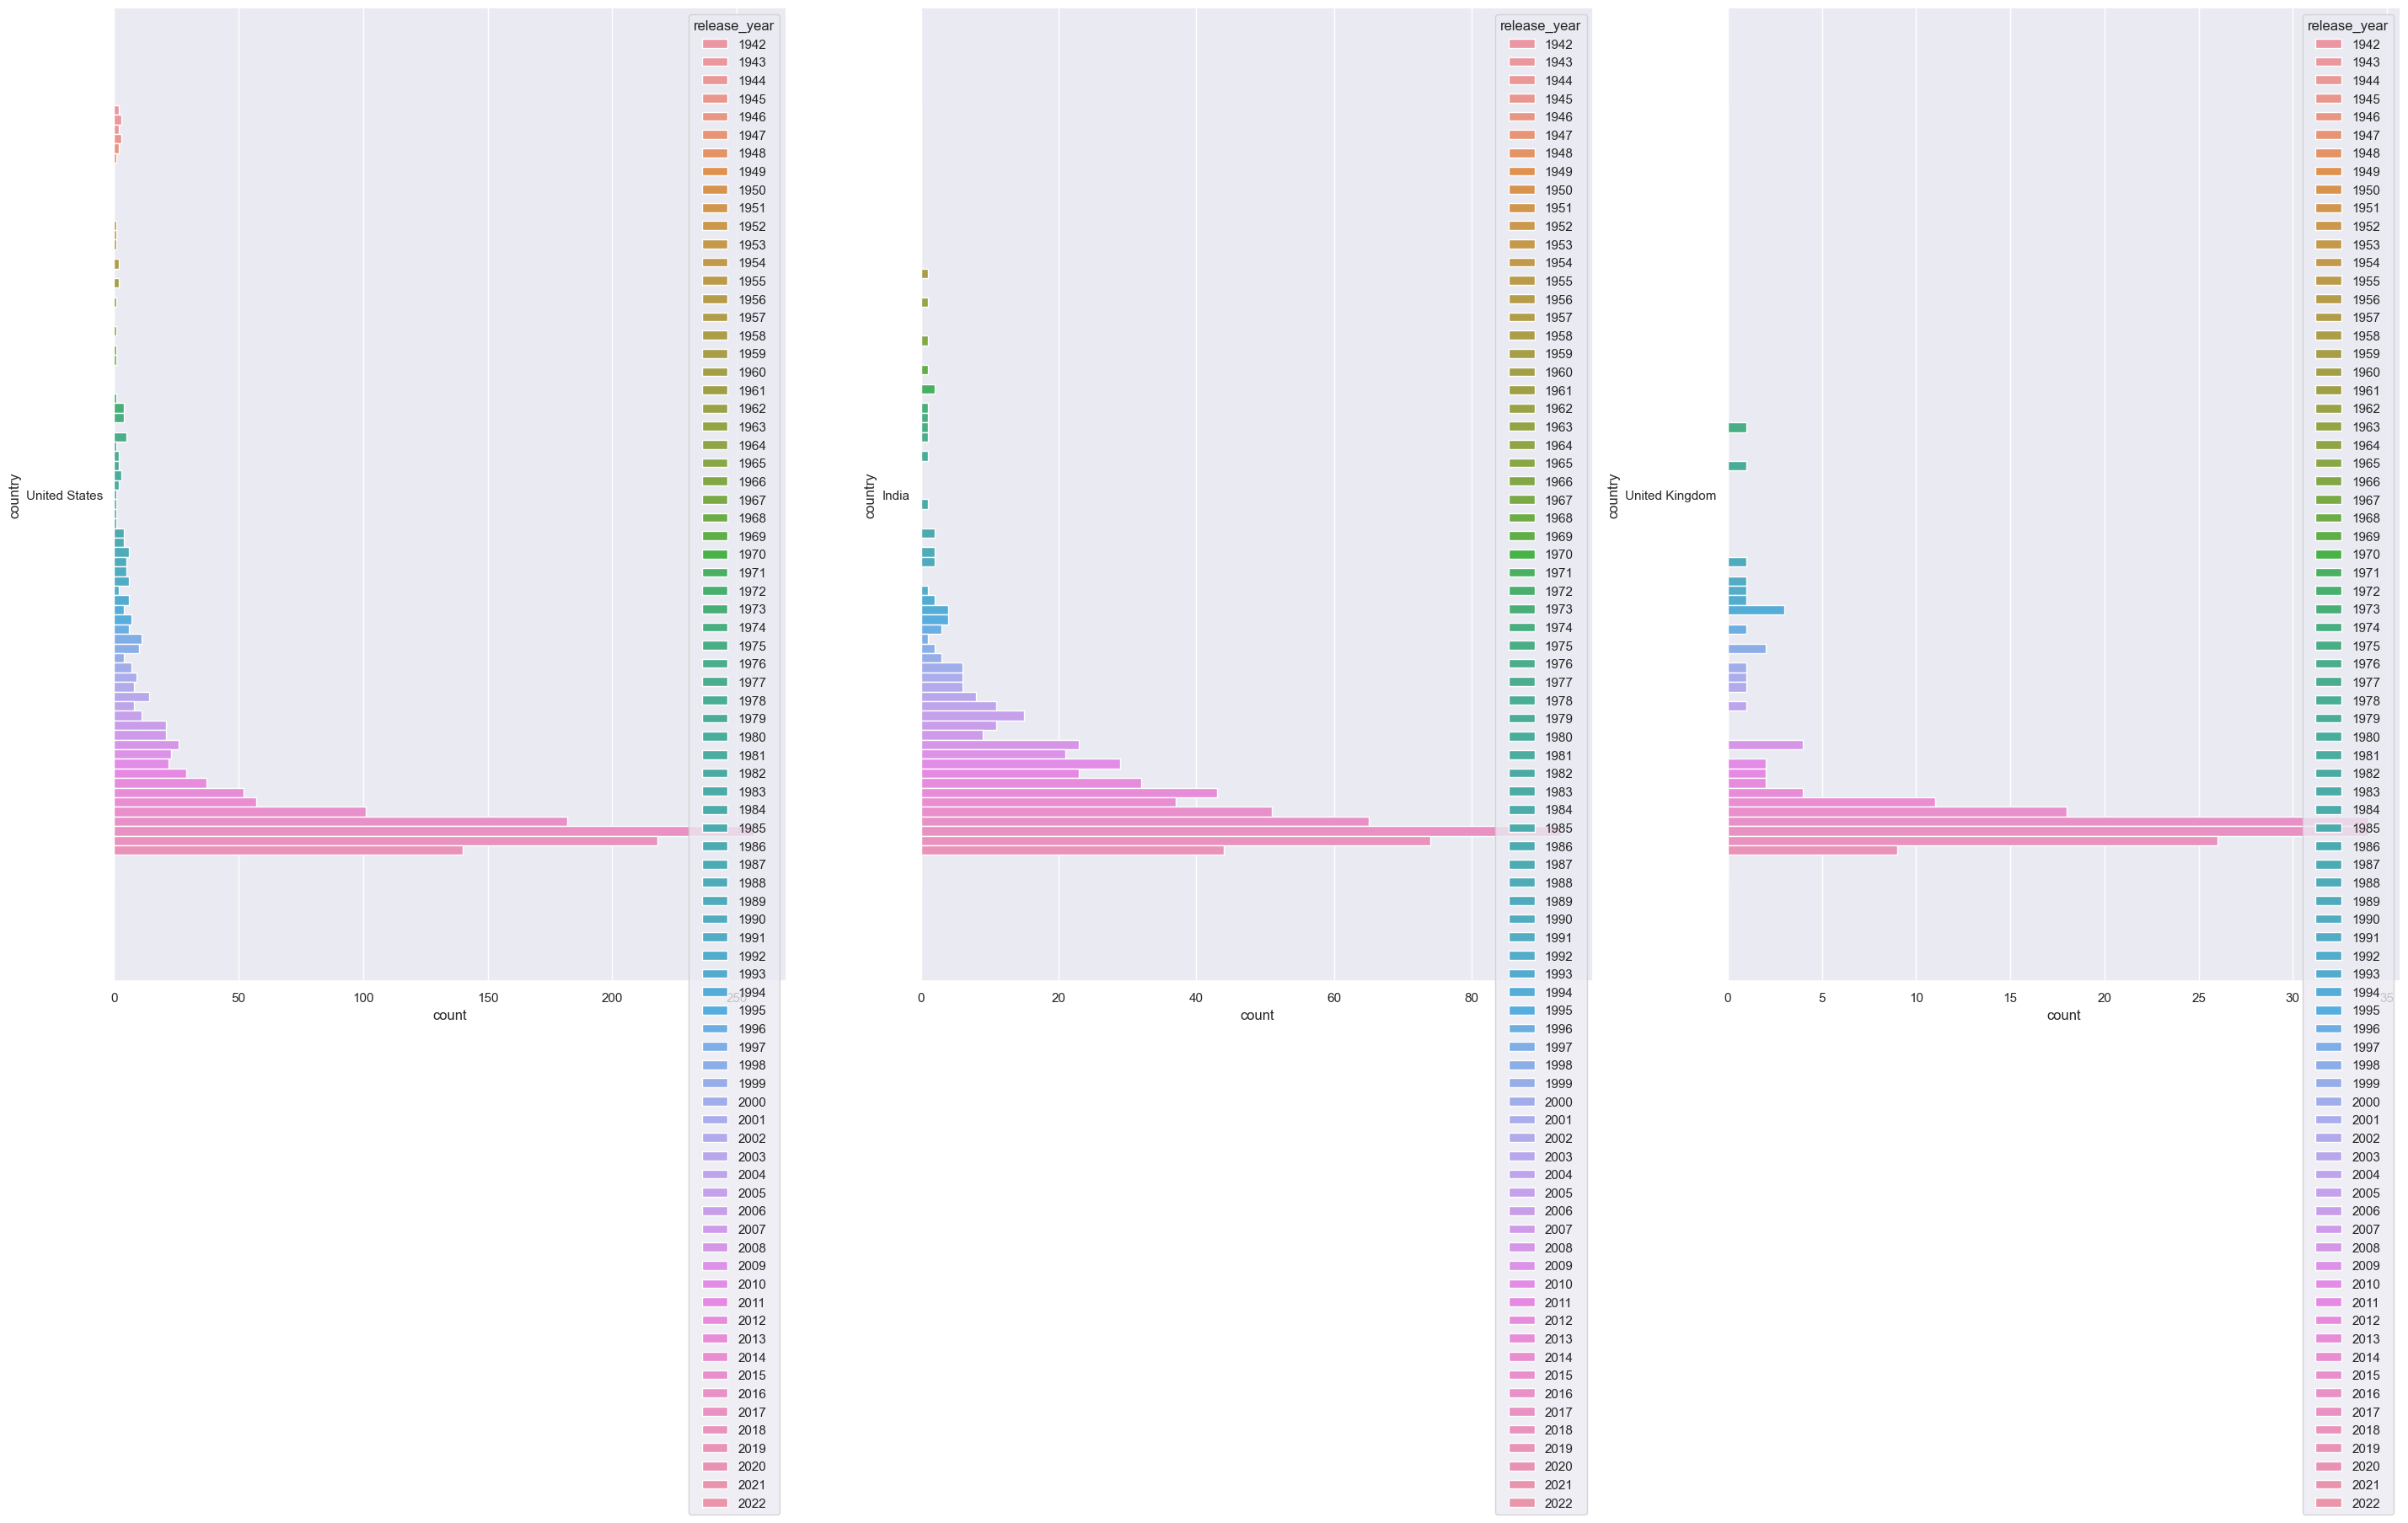

In [207]:
fig, axs = plt.subplots(
    ncols=3,
    figsize=(35,15)
    );

sns.barplot(
    movies_US,
    x="count",
    y="country",
    hue="release_year",
    orient='h',
    ax=axs[0]
);

sns.barplot(
    movies_INDIA,
    x="count",
    y="country",
    hue="release_year",
    orient='h',
    ax=axs[1]
);

sns.barplot(
    movies_UK,
    x="count",
    y="country",
    hue="release_year",
    orient='h',
    ax=axs[2]
);

## Deeper analysis / If we had time - Ryan / Karen
- How does this data correspond to all movies not just movies on netflix?>
- How quickly do movies appear on netflix after being released?
- Top actors on netflix?
  - Top actors on netflix per country?
- Top Directors on netflix?
  - Top Directors on netflix per country?
- min vs max of duration (movies & tv show)
- We'd clean up the graph to make each country more comparible

# REMOVED CODE

In [176]:
# sensible_genres = []
# for i in cleaned_df["genres"].astype("string"): # Use .astype string to avoid issues down line. Category has issues
#     if ',' in i:
#         i = list(set(i.split(", "))) # Remove duplicates using set
#         k = ''
#         index = len(i)-1
#         for e,j in enumerate(i):
#             if (e == index):
#                 j = genre_map[j]
#                 k += j
#             else:
#                 j = genre_map[j]
#                 k += j + ','
#         sensible_genres.append(k)
#     else:
#         i = genre_map[str(i)]
#         sensible_genres.append(i)
# sensible_genres = pd.Series(sensible_genres).astype("category") # Convert to a category
# cleaned_df["_genres"] = sensible_genres
# cleaned_df.head()